<a href="https://colab.research.google.com/github/TheRadDani/Mobilenetv3-benchmark/blob/main/MobileNetv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-4s3n5g86
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-4s3n5g86
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=386214 sha256=a20ee1891bd5dab4389c58b72f0d5e2d00a3bcfed4d512d1322c7bbcd8369de3
  Stored in directory: /tmp/pip-ephem-wheel-cache-fhoqd3n7/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.

In [2]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [163]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import CocoDetection
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchinfo import summary
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [208]:
config = {
    "BATCH_SIZE": 32,
    'DEVICE': "cuda" if torch.cuda.is_available() else "cpu",
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 1e-3,
    "max_lr" : 0.01,
    "grad_clip" : 0.1,
    "weight_decay" : 1e-4,
    "opt_func" : torch.optim.Adam,
    "N_DENSE_1": 512,
    "N_DENSE_2": 128,
}

In [186]:
import torchvision.datasets as datasets
train_dataset = datasets.SVHN(root='./data', split='train', download=True)
test_dataset = datasets.SVHN(root='./data', split='test', download=True)

100%|██████████| 182040794/182040794 [00:06<00:00, 29959203.97it/s]


100%|██████████| 64275384/64275384 [00:03<00:00, 20171357.85it/s]


In [165]:
dataset_config = {
    'cifar10':
    {
        'dataset_url' : "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz",
        'file':'cifar10.tgz',
        'num_classes' : 10,
        'stats' : ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    },

    'cifar100' :
     {
        'dataset_url' : "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz",
        'file':'cifar100.tgz',
        'num_classes' : 100,
        'stats' : ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
     },
     'SVHN' :
     {
        'dataset_url' : "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz",
        'file':'cifar100.tgz',
        'num_classes' : 100,
        'stats' : ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
     },
    'coco2017':
    {
        
    },
    'imagenet':
    {
        'dataset_url' : "http://www.image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_img_train.tar.gz",
        'file':"ILSVRC2012_img_train.tar.gz",
        'num_classes' : 1000,
        'stats' : ((0.485,0.456,0.406), (0.229, 0.224, 0.225))
    },
    'human_emotions':
    {
        'size' : (224, 224),
        'num_classes' : 3,
        'stats' : ((0.485,0.456,0.406), (0.229, 0.224, 0.225)),
        'class_names' : ["angry", "happy", "sad"],
    }
   }

In [103]:
class Dataset():
    def __init__(self,dataset):
        self.dataset = dataset
        self.stats = dataset_config[self.dataset]['stats']
        self.file = dataset_config[self.dataset]["file"].split('.')[0]
        self.data_dir = f'./{self.file}/{self.file}'
    
    def get_dataset(self):
      download_url(dataset_config[self.dataset]['dataset_url'], './')

      # Extract from archive

      with tarfile.open(f'./{dataset_config[self.dataset]["file"]}', 'r:gz') as tar:
          tar.extractall(path=f'./{self.file}')
              
    def data_augmentation(self):
        # Data transforms (normalization & data augmentation)
        
        train_tfms = tt.Compose([
                                tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                                 tt.RandomHorizontalFlip(), 
                                 #tt.RandomRotate,
                                 tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                                 tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                 tt.Resize((224, 224),interpolation=tt.InterpolationMode.BILINEAR),  # Resize the image to 256x256
                                 tt.ToTensor(), 
                                 tt.Normalize(*self.stats,inplace=True)])
        valid_tfms = tt.Compose([
                                tt.Resize((224, 224),interpolation=tt.InterpolationMode.BILINEAR),  # Resize the image to 256x256
                                tt.ToTensor(),
                                tt.Normalize(*self.stats)])

        return (train_tfms,valid_tfms)

    def dataset_creation(self):
      from torchvision.models import MobileNet_V3_Small_Weights

      weights = MobileNet_V3_Small_Weights.DEFAULT
      preprocess = weights.transforms()
      train_tfms, valid_tfms = self.data_augmentation()

      '''train_ds = ImageFolder(self.data_dir+'/train', transform=train_tfms)
      valid_ds = ImageFolder(self.data_dir+'/test', transform =valid_tfms)'''
      train_ds = ImageFolder(self.data_dir+'/train', transform = preprocess)
      valid_ds = ImageFolder(self.data_dir+'/test', transform = valid_tfms)
      return (train_ds,valid_ds)
    
    def get_classes(self):

      classes = os.listdir(self.data_dir + "/train")
      return classes

    def data_loaders(self):

      train_ds,valid_ds = self.dataset_creation()
      train_dl = DataLoader(train_ds, config['BATCH_SIZE'], shuffle=True, num_workers=3, pin_memory=True)
      val_dl = DataLoader(valid_ds, config['BATCH_SIZE']*2, num_workers=3, pin_memory=True)
      return (train_dl,val_dl)

    def denormalize(self,images, means, stds):
      means = torch.tensor(means).reshape(1, 3, 1, 1)
      stds = torch.tensor(stds).reshape(1, 3, 1, 1)
      return images * stds + means

    def show_batch(self,dl):
      for images, labels in dl:
          fig, ax = plt.subplots(figsize=(12, 12))
          ax.set_xticks([]); ax.set_yticks([])
          denorm_images = self.denormalize(images, *self.stats)
          ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
          break

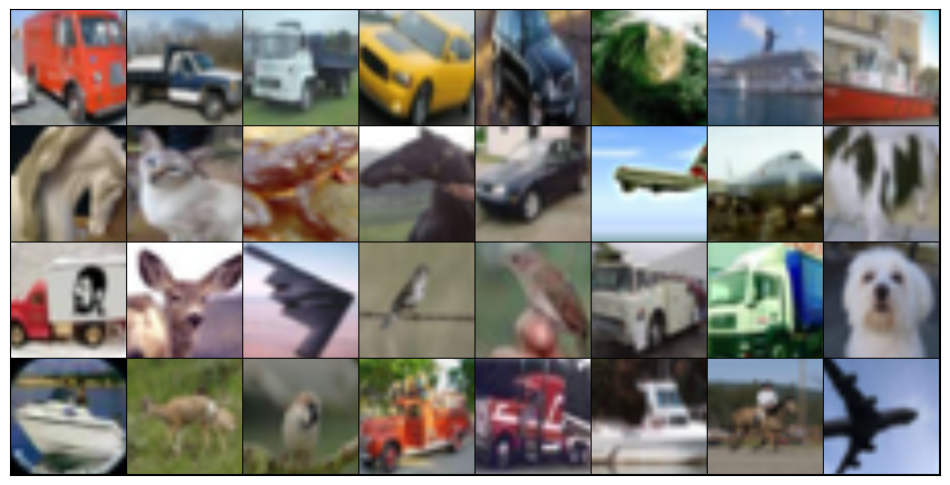

In [104]:
dataset = Dataset('cifar10')
train_dl,val_dl = dataset.data_loaders()
dataset.show_batch(train_dl)

In [105]:
next(iter(train_dl))[0].shape

torch.Size([32, 3, 224, 224])

In [179]:
def to_device(data,device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl):
        self.dl = dl
        self.device = config['DEVICE']
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [95]:
train_dl = DeviceDataLoader(train_dl)
valid_dl = DeviceDataLoader(val_dl)

In [212]:
from torch.nn.modules.activation import ReLU
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

def count_layers(model):
  return sum(1 for _ in model.named_parameters())

class MobileNetV3Custom(nn.Module):
  '''
  Class that trains the backbone network with a defined number 
  of layers, where None means all layers will be trainable.
  If a specific number is provided, it will determine
  the number of layers to train starting from the head of the model.
  '''

  def __init__(self, dataset,train=True,num_layers_train=0):
    super(MobileNetV3Custom, self).__init__()
    self.num_classes = dataset_config[dataset]['num_classes']
    self.num_layers_train = num_layers_train
    self.device = config['DEVICE']
    # Load the MobileNetV3 model
    if not train:
      self.device = torch.device('cpu')
    self.base_model = mobilenet_v3_small(
      weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1).to(self.device)
    self.weights = MobileNet_V3_Small_Weights.DEFAULT

    # Determine the number of layers to train
    

    total_layers = count_layers(self.base_model)
    # Determine the number of layers to train
    if num_layers_train is None or num_layers_train > total_layers:
        num_layers_train = total_layers

    # Freeze or train the specified number of layers
    for i, param in enumerate(self.base_model.parameters()):
        if i < total_layers - num_layers_train:
            param.requires_grad = False

    # Adjust the last dense layer for the new number of classes
    num_dense_nodes = self.base_model.classifier[-1].out_features
    #self.base_model.classifier[-1] = nn.Linear(num_dense_nodes, 512)
    self.base_model.fc = self.fc = nn.Sequential(
      nn.Linear(num_dense_nodes, config['N_DENSE_1']),
      nn.ReLU(inplace=True),
      nn.Linear(config['N_DENSE_1'], config['N_DENSE_2']),
      nn.ReLU(inplace=True),
      nn.Linear(config['N_DENSE_2'], self.num_classes),
      nn.Softmax(dim=1)
    )

        
  def forward(self, x):
    x = self.base_model(x) 
    x = self.fc(x)
    return x
  

  def model_input_size(self):
    return self.base_model.classifier#[0][0]#.in_channels


  def preprocess(self):
    preprocess = self.weights.transforms()
    return preprocess

In [213]:
model = MobileNetV3Custom('cifar10')

BATCH_SIZE = config['BATCH_SIZE']
summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MobileNetV3Custom (MobileNetV3Custom)                             [32, 3, 224, 224]    [32, 10]             --                   Partial
├─MobileNetV3 (base_model)                                        [32, 3, 224, 224]    [32, 1000]           579,466              Partial
│    └─Sequential (features)                                      [32, 3, 224, 224]    [32, 576, 7, 7]      --                   False
│    │    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 16, 112, 112]   (464)                False
│    │    └─InvertedResidual (1)                                  [32, 16, 112, 112]   [32, 16, 56, 56]     (744)                False
│    │    └─InvertedResidual (2)                                  [32, 16, 56, 56]     [32, 24, 28, 28]     (3,864)              False
│    │    └─InvertedResidual (3)               

In [202]:
model.base_model.fc

Sequential(
  (0): Linear(in_features=1000, out_features=512, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=512, out_features=10, bias=True)
  (3): Softmax(dim=1)
)

In [155]:
model.model_input_size()

AttributeError: ignored

In [154]:
model.features

AttributeError: ignored

In [145]:
model.model_input_size()

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)

In [59]:
def count_layers(model):
    return sum(1 for _ in model.named_parameters())

total_layers = count_layers(model)
print("Total number of layers in the model:", total_layers)

Total number of layers in the model: 142


In [60]:
total_parameters = sum(p.numel() for p in model.parameters())

print(f"Total number of layers: {total_parameters}")

Total number of layers: 2542856


In [161]:
for name,param in model.named_parameters():

    if 'weight in name':
        print(f'{name}: {param.data.cpu().numpy()}')
    elif 'bias in name':
        print(f'{name} : {param.data.cpu().numpy()}')

base_model.features.0.0.weight: [[[[ 8.89096200e-01  1.16306686e+00  1.00914109e+00]
   [ 9.59303856e-01  1.21928990e+00  9.63840902e-01]
   [ 6.53132126e-02  1.52925566e-01  1.47109209e-02]]

  [[-7.81511784e-01 -9.79279816e-01 -8.64420176e-01]
   [-8.06397617e-01 -1.00206172e+00 -7.89333105e-01]
   [-5.66657633e-02 -1.23549424e-01 -3.55118215e-02]]

  [[-5.14254570e-02 -7.30416998e-02 -7.56048560e-02]
   [-6.28442392e-02 -8.13054964e-02 -7.08968416e-02]
   [-1.31652774e-02 -1.21082952e-02  9.39625036e-03]]]


 [[[-2.51469985e-02 -1.23937577e-02 -3.10391560e-03]
   [ 3.86731029e-01  7.36739159e-01  4.20377702e-01]
   [-3.78187209e-01 -7.08123147e-01 -3.95417899e-01]]

  [[ 1.45236431e-02  1.73632633e-02  4.07615816e-03]
   [ 8.02594125e-01  1.66471136e+00  9.07911777e-01]
   [-7.93979466e-01 -1.69400418e+00 -9.35877800e-01]]

  [[ 1.41365230e-02  3.22268717e-02  1.40442299e-02]
   [ 1.64783001e-01  2.87256241e-01  1.48075059e-01]
   [-1.54891744e-01 -2.91364282e-01 -1.75017595e-01]]]


In [173]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch 
    out = self(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss
  
  def validation_step(self, batch):
    images, labels = batch 
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}
      
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [180]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    for i, (image, label) in enumerate(val_loader):
      image = image.to('cpu')
      label = label.to('cpu')
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
      return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []
  
  # Set up cutom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  # Set up one-cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                              steps_per_epoch=len(train_loader))
  
  for epoch in range(epochs):
      # Training Phase 
      model.train()
      train_losses = []
      lrs = []
      for batch in train_loader:
          loss = model.training_step(batch)
          train_losses.append(loss)
          loss.backward()
          
          # Gradient clipping
          if grad_clip: 
              nn.utils.clip_grad_value_(model.parameters(), grad_clip)
          
          optimizer.step()
          optimizer.zero_grad()
          
          # Record & update learning rate
          lrs.append(get_lr(optimizer))
          sched.step()
      
      # Validation phase
      result = evaluate(model, val_loader)
      result['train_loss'] = torch.stack(train_losses).mean().item()
      result['lrs'] = lrs
      model.epoch_end(epoch, result)
      history.append(result)
  return history

In [181]:
history = [evaluate(model, valid_dl)]
history

AttributeError: ignored

In [167]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

In [168]:
#plot_accuracies(history)

In [169]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
# plot_losses(history)

In [ ]:
torch.save(model.state_dict(), 'cifar10-mobilenetv3.pth')

In [ ]:
model = torchvision.models.mobilenet_v3_small(pretrained = True).to(config['DEVICE'])

C:\Users\l0f05t8\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\l0f05t8\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\l0f05t8/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100%|█████████████████████████████████████████████████████████████████████████████| 9.83M/9.83M [00:08<00:00, 1.28MB/s]


In [79]:
object_detection_model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1`. You can also use `weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100%|██████████| 13.4M/13.4M [00:00<00:00, 31.2MB/s]


In [82]:
'''def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat'''

"def compute_confusion_matrix(model, data_loader, device):\n\n    all_targets, all_predictions = [], []\n    with torch.no_grad():\n\n        for i, (features, targets) in enumerate(data_loader):\n\n            features = features.to(device)\n            targets = targets\n            logits = model(features)\n            _, predicted_labels = torch.max(logits, 1)\n            all_targets.extend(targets.to('cpu'))\n            all_predictions.extend(predicted_labels.to('cpu'))\n\n    all_predictions = all_predictions\n    all_predictions = np.array(all_predictions)\n    all_targets = np.array(all_targets)\n\n    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))\n    if class_labels.shape[0] == 1:\n        if class_labels[0] != 0:\n            class_labels = np.array([0, class_labels[0]])\n        else:\n            class_labels = np.array([class_labels[0], 1])\n    n_labels = class_labels.shape[0]\n    lst = []\n    z = list(zip(all_targets, all_predictions))\n  